> A basic introduction to geospatial grids

[![](https://colab.research.google.com/assets/colab-badge.svg "Open in Colab button")](https://colab.research.google.com/github/thinkingmachines/geowrangler/blob/master/notebooks/tutorial.grids.ipynb)

In [ ]:
#| include: false
# all_slow

In [ ]:
#| include: false
#| no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [ ]:
#| include: false
#| no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Basic Usage
Creating a grid from a geojson file

In [ ]:
#| include: false
import warnings

from IPython.display import display

In [ ]:
#| include: false
warnings.filterwarnings("ignore")

### Import `geopandas` and the `geowrangler.grids` module

In [ ]:
import geopandas as gpd
import pandas as pd

from geowrangler import grids

In [ ]:
#| include: false
#| no_test
!mkdir -p ../data
# download sample geojson file from repo
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson

### Load a sample geojson file into pandas 


In our case, we are loading the Region 3 (Central Luzon Administrative Region) of the Philippines.

In [ ]:
region3_gdf = gpd.read_file("../data/region3_admin.geojson")

This geopandas dataframe has the size: 

In [ ]:
#| echo: false
print(f"length of region3_gdf: {len(region3_gdf)} row(s)")

length of region3_gdf: 1 row(s)


In [ ]:
display(region3_gdf)

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ..."


Show the original plot

In [ ]:
import matplotlib.pyplot as plt

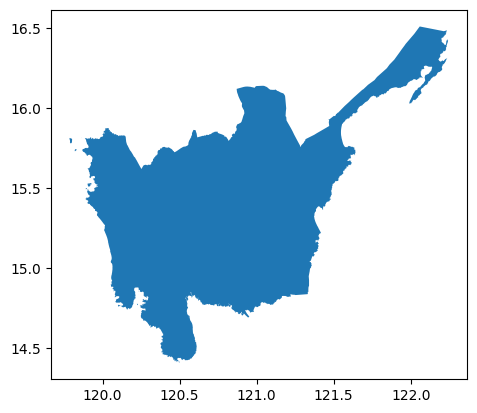

In [ ]:
ax = region3_gdf.plot(ax=plt.axes())

In [ ]:
region3_gdf.crs  # CRS info

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
aoi_total_bounds = region3_gdf.total_bounds
aoi_total_bounds

array([119.7858332,  14.4075257, 122.2429921,  16.5092548])

## Square Grid Generator
### Creating Grids

Create a grid generator with a size of `5,000` m. 
The units of the grid size are dependent on the projection parameter  
of the grid generator. In this case, the [default is  `EPSG:3857`](https://epsg.io/3857).

In [ ]:
grids.SquareGridGenerator?

Init signature:
grids.SquareGridGenerator(
    cell_size: float,
    grid_projection: str = 'EPSG:3857',
    boundary: Union[geowrangler.grids.SquareGridBoundary, List[float], Tuple[float]] = None,
)
Docstring:      <no docstring>
File:           ~/github-repos/geowrangler/geowrangler/grids.py
Type:           type
Subclasses:     

In [ ]:
grid_generator5k = grids.SquareGridGenerator(5_000)  # 5 km x 5 km square cells

Generate square grids
> Notice the time taken to grid the multi polygon at 5K resolution


In [ ]:
%%time
grid_gdf5k = grid_generator5k.generate_grid(region3_gdf)

CPU times: user 350 ms, sys: 41.1 ms, total: 391 ms
Wall time: 392 ms


<Axes: >

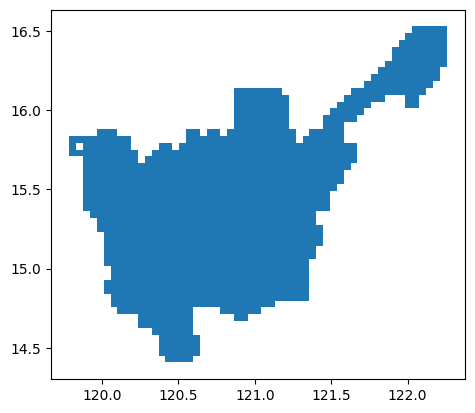

In [ ]:
grid_gdf5k.plot()

Show gridded version of sample geojson file at 5K resolution 

In [ ]:
#| echo: false
#| no_test
print(f"length of grid_gdf5k: {len(grid_gdf5k)} row(s)")

length of grid_gdf5k: 1074 row(s)


In [ ]:
#| include: false
assert len(grid_gdf5k) == 1074

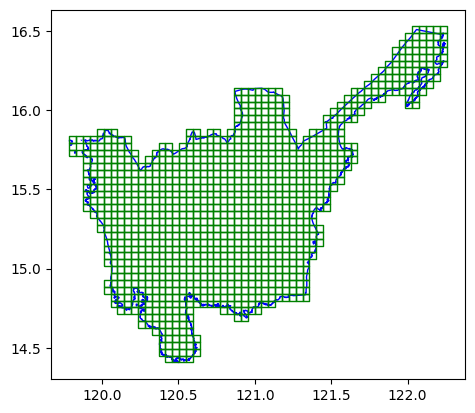

In [ ]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k.plot(ax=ax, facecolor="none", edgecolor="green")

In addition to the grid cells, there are 2 extra columns `x` and `y` when combined are unique per grid. It can also tell us which grids are adjacent to each other. 

In [ ]:
grid_gdf5k.head()

,x,y,geometry
0,7,8,"POLYGON ((120.10024 14.75528, 120.14516 14.755..."
1,6,8,"POLYGON ((120.05533 14.75528, 120.10024 14.755..."
2,9,8,"POLYGON ((120.19008 14.75528, 120.23499 14.755..."
3,2,24,"POLYGON ((119.87566 15.4491, 119.92058 15.4491..."
4,2,25,"POLYGON ((119.87566 15.49239, 119.92058 15.492..."


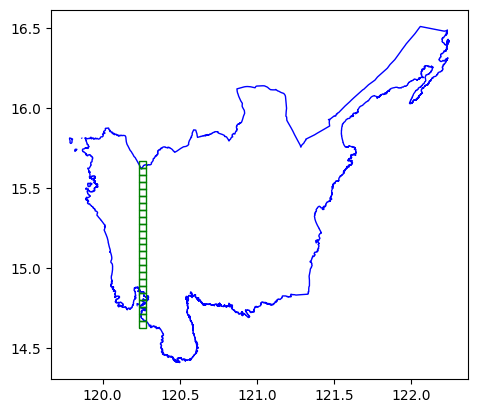

In [ ]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k[grid_gdf5k["x"] == 10].plot(ax=ax, facecolor="none", edgecolor="green")

### Gridding at a coarser resolution
Let's try the same process but with a bigger grid (15K)

In [ ]:
grid_generator15k = grids.SquareGridGenerator(15_000)  # 15 km x 15 km grids

Generate square grids
> Notice the time taken to grid the multi polygon at 15K resolution (compared to 5K resolution)


In [ ]:
%%time
grid_gdf15k = grid_generator15k.generate_grid(region3_gdf)

CPU times: user 309 ms, sys: 28.6 ms, total: 337 ms
Wall time: 337 ms


<Axes: >

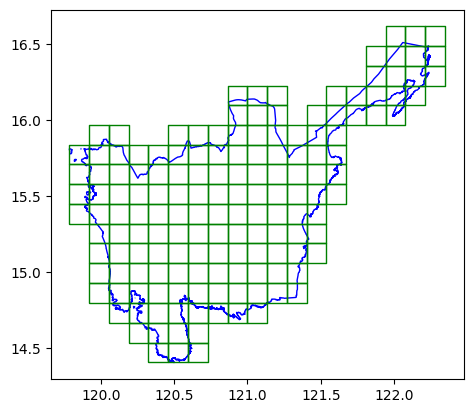

In [ ]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")

Show gridded version of sample geojson file at 15K resolution 

In [ ]:
#| echo: false
print(f"length of grid_gdf15k: {len(grid_gdf15k)} row(s)")

length of grid_gdf15k: 154 row(s)


In [ ]:
#| include: false
assert len(grid_gdf15k) == 154

### Reusing boundaries
If you have 2 polygons that are far from each other but wish to have them follow the reference same reference `x` and `y`, you can use pass in custom boudaries. 

Let's load some grids that are from each other

In [ ]:
cell1 = grid_gdf15k.head(1)
cell2 = grid_gdf15k.tail(1)

In [ ]:
pd.concat([cell1, cell2])

,x,y,geometry
0,2,2,"POLYGON ((120.05533 14.66839, 120.19008 14.668..."
153,18,16,"POLYGON ((122.21128 16.48548, 122.34603 16.485..."


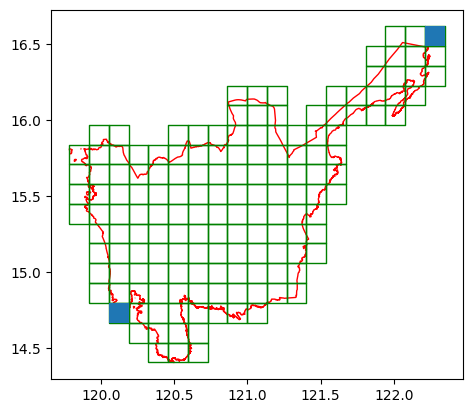

In [ ]:
ax = region3_gdf.plot(facecolor="none", edgecolor="red")
ax = grid_gdf15k.plot(ax=ax, facecolor="none", edgecolor="green")
ax = pd.concat([cell1, cell2]).plot(ax=ax)

In [ ]:
grid_generator1k = grids.SquareGridGenerator(1_000, boundary=aoi_total_bounds)

In [ ]:
%%time
gridcell1 = grid_generator1k.generate_grid(cell1)

CPU times: user 10.9 ms, sys: 2.79 ms, total: 13.7 ms
Wall time: 11.8 ms


In [ ]:
len(gridcell1)

289

In [ ]:
gridcell1.head()

,x,y,geometry
0,29,29,"POLYGON ((120.04634 14.6597, 120.05533 14.6597..."
1,29,30,"POLYGON ((120.04634 14.66839, 120.05533 14.668..."
2,29,31,"POLYGON ((120.04634 14.67708, 120.05533 14.677..."
3,29,32,"POLYGON ((120.04634 14.68577, 120.05533 14.685..."
4,29,33,"POLYGON ((120.04634 14.69446, 120.05533 14.694..."


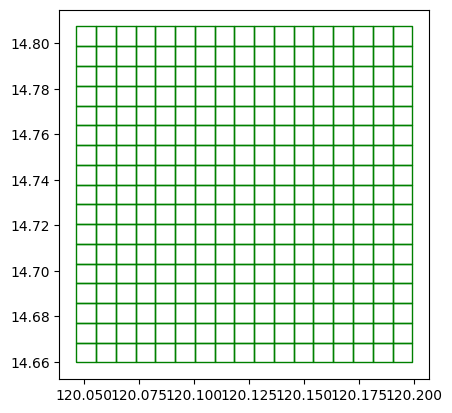

In [ ]:
ax = gridcell1.plot(facecolor="none", edgecolor="green")

In [ ]:
%%time
gridcell2 = grid_generator1k.generate_grid(cell2)

CPU times: user 4.96 ms, sys: 887 µs, total: 5.84 ms
Wall time: 5.16 ms


In [ ]:
len(gridcell2)

20

In [ ]:
gridcell2.head()

,x,y,geometry
0,269,239,"POLYGON ((122.2023 16.47686, 122.21128 16.4768..."
1,269,240,"POLYGON ((122.2023 16.48548, 122.21128 16.4854..."
2,269,241,"POLYGON ((122.2023 16.49409, 122.21128 16.4940..."
3,269,242,"POLYGON ((122.2023 16.5027, 122.21128 16.5027,..."
4,270,239,"POLYGON ((122.21128 16.47686, 122.22027 16.476..."


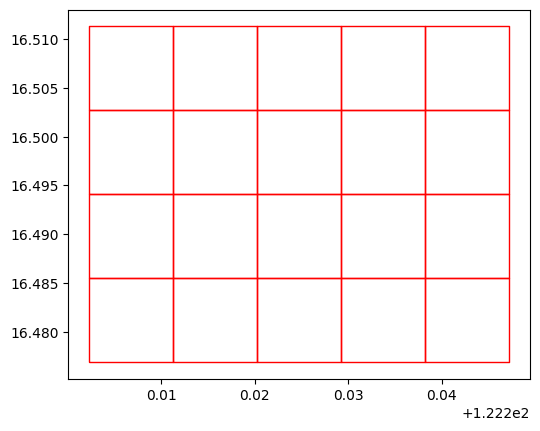

In [ ]:
ax = gridcell2.plot(facecolor="none", edgecolor="red")

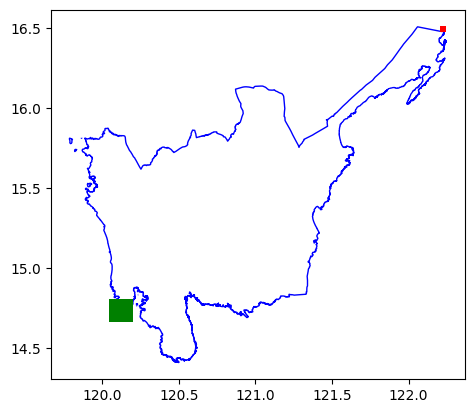

In [ ]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = gridcell1.plot(ax=ax, color="green")
ax = gridcell2.plot(ax=ax, color="red")

## Generating grids for multiple distant areas
If you are using AOIs that are vary far from each other, Grid Generator already optmizes the implementation for you


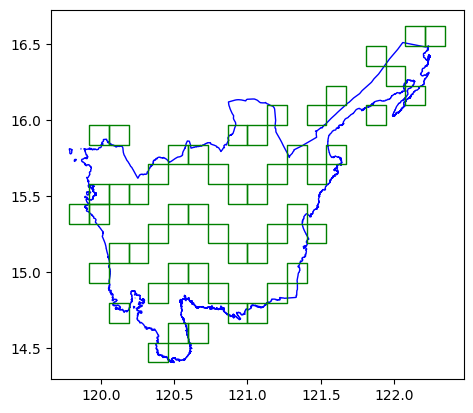

In [ ]:
sparse_aois = grid_gdf15k.iloc[
    0:1000:3,
]  # Get areas that far from each other
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_aois.plot(ax=ax, facecolor="none", edgecolor="green")

In [ ]:
sparse_grid = grid_generator1k.generate_grid(sparse_aois)

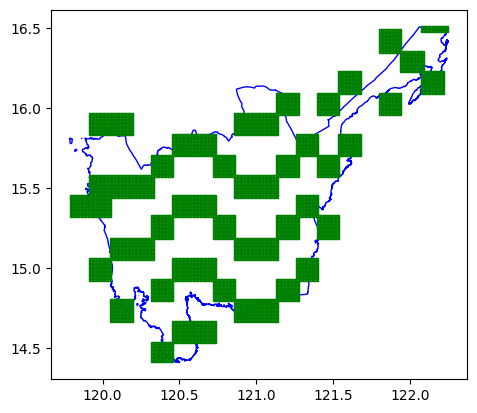

In [ ]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = sparse_grid.plot(ax=ax, facecolor="none", edgecolor="green")

It is a bit hard to see the grids so, we get a subset to verify.

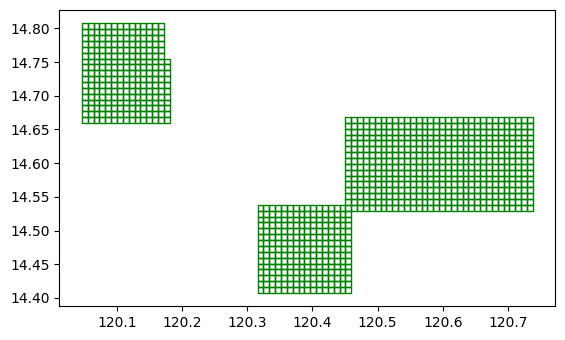

In [ ]:
ax = sparse_grid.head(1000).plot(facecolor="none", edgecolor="green")

## Fast Square Grid Generator

We can use `FastSquareGridGenerator` for significantly faster grid generation.

In [ ]:
fast_grid_generator5k = grids.FastSquareGridGenerator(5_000)  # 5 km x 5 km square cells

In [ ]:
%%time
fast_grid_gdf5k = fast_grid_generator5k.generate_grid(region3_gdf)
fast_grid_gdf5k.head()

CPU times: user 64.1 ms, sys: 47.3 ms, total: 111 ms
Wall time: 61.5 ms


,x,y,geometry
0,26,21,"POLYGON ((120.99856 15.31919, 120.99856 15.362..."
1,18,17,"POLYGON ((120.63923 15.14583, 120.63923 15.189..."
2,15,30,"POLYGON ((120.50449 15.7087, 120.50449 15.7519..."
3,7,26,"POLYGON ((120.14516 15.53567, 120.14516 15.578..."
4,26,39,"POLYGON ((120.99856 16.09747, 120.99856 16.140..."


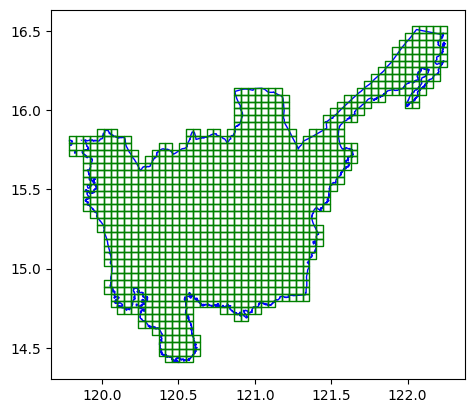

In [ ]:
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = fast_grid_gdf5k.plot(ax=ax, facecolor="none", edgecolor="green")

Since `FastSquareGridGenerator` uses a different algorithm to find the tiles inside a polygon, the tiles aren't always exact but it's typically close.

In the case below, there's a 1 tile mismatch. There's 1 tile available in `SquareGridGenerator` but not in `FastSquareGridGenerator`. This typically happens on some corners of polygons.

In [ ]:
grid_gdf5k.shape[0], fast_grid_gdf5k.shape[0]

(1074, 1073)

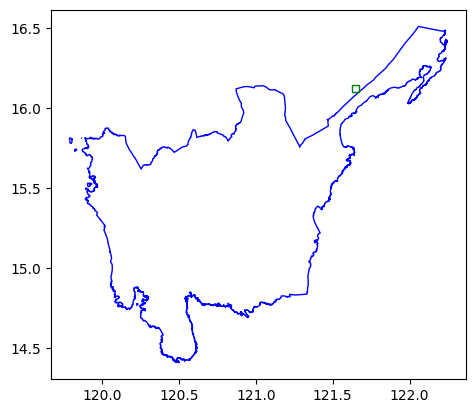

In [ ]:
#| no_test

grid_gdf5k["xy_key"] = grid_gdf5k.apply(lambda row: f"{row['x']}-{row['y']}", axis=1)
fast_grid_gdf5k["xy_key"] = fast_grid_gdf5k.apply(lambda row: f"{row['x']}-{row['y']}", axis=1)

bool_mask = ~grid_gdf5k["xy_key"].isin(fast_grid_gdf5k["xy_key"])
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = grid_gdf5k.loc[bool_mask,:].plot(ax=ax, facecolor="none", edgecolor="green")

We can even use a more granular cell_size, say 500m, and `FastSquareGridGenerator` will still run for around the same time as `SquareGridGenerator` at 5000m cell_size despite the former having ~88 times more grid tiles.

We can also pass in a column name to `unique_id_col` so that the grids can preserve the ID from the AOI. This makes it convenient so you don't have to do another spatial intersection between the tiles gdf and the AOI gdf to get the AOI IDs.

In [ ]:
fast_grid_generator500 = grids.FastSquareGridGenerator(500)  # 500 m x 500 m square cells

In [ ]:
%%time
fast_grid_gdf500 = fast_grid_generator500.generate_grid(region3_gdf, unique_id_col="Reg_Name")
fast_grid_gdf500.head()

CPU times: user 439 ms, sys: 57.5 ms, total: 496 ms
Wall time: 453 ms


,x,y,Reg_Name,geometry
0,155,8,Region III,"POLYGON ((120.48652 14.44233, 120.48652 14.446..."
1,479,413,Region III,"POLYGON ((121.94179 16.1967, 121.94179 16.2010..."
2,142,182,Region III,"POLYGON ((120.42813 15.19785, 120.42813 15.202..."
3,352,227,Region III,"POLYGON ((121.37136 15.39282, 121.37136 15.397..."
4,369,257,Region III,"POLYGON ((121.44772 15.52269, 121.44772 15.527..."


In [ ]:
fast_grid_gdf500.shape[0]

94057

In [ ]:
# computes how many more tiles there are in FastSquareGridGenerator 500m vs SquareGridGenerator 5000m
fast_grid_gdf500.shape[0]/grid_gdf5k.shape[0]

87.57635009310987

## H3 Grid Generator
### Generating grids
Let us generate grids of resolution 5. To learn more about the different resolution, visit: https://h3geo.org/docs/core-library/restable/

In [ ]:
h3_generator = grids.H3GridGenerator(resolution=5)

In [ ]:
%%time
h3_5_gdf = h3_generator.generate_grid(region3_gdf)

CPU times: user 1.17 s, sys: 41 ms, total: 1.21 s
Wall time: 1.22 s


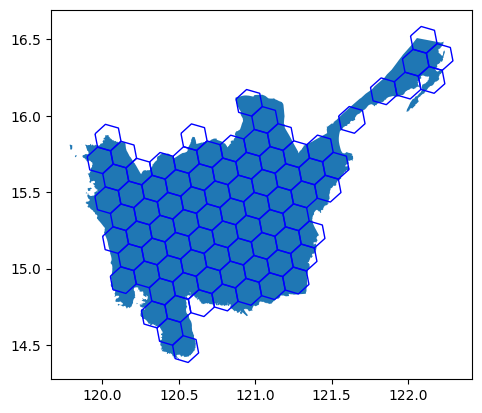

In [ ]:
ax = region3_gdf.plot(aspect="equal")
ax = h3_5_gdf.plot(ax=ax, facecolor="none", edgecolor="blue", aspect="equal")

### Not exporting geometry
If you do not plan to use use geometry, you can pass `return_geometry=False` to just get a normal pandas DataFrame with the ids.

In [ ]:
h3_generator_no_geom = grids.H3GridGenerator(resolution=5, return_geometry=False)

In [ ]:
%%time
h3_region3_no_geom = h3_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 1.16 s, sys: 44.8 ms, total: 1.21 s
Wall time: 1.21 s


In [ ]:
len(h3_region3_no_geom)

84

In [ ]:
h3_region3_no_geom.head()

,hex_id
0,8569411bfffffff
1,85694107fffffff
2,85694127fffffff
3,85694123fffffff
4,85694563fffffff


## Bing Tile Grid Generator
### Generating grids
Let us generate grids of zoom_level 12. To learn more about the different resolution, visit: https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system

In [ ]:
bing_tile_grid_generator = grids.BingTileGridGenerator(12)

In [ ]:
%%time
# slow
bing_tile_gdf = bing_tile_grid_generator.generate_grid(region3_gdf)

CPU times: user 3.24 s, sys: 54.4 ms, total: 3.3 s
Wall time: 3.36 s


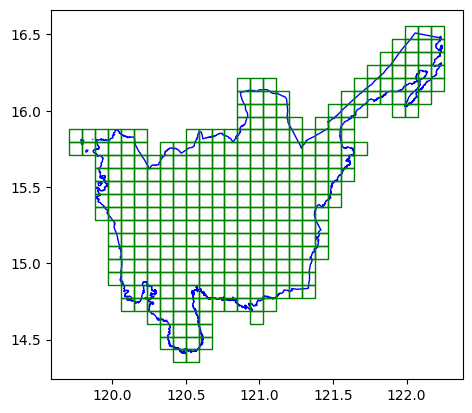

In [ ]:
#| no_test
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = bing_tile_gdf.plot(ax=ax, facecolor="none", edgecolor="green")

### Not exporting geometry

If you do not plan to use use geometry, you can pass return_geometry=False to just get a normal pandas DataFrame with the ids.


In [ ]:
bing_tile_grid_generator_no_geom = grids.BingTileGridGenerator(
    12, return_geometry=False
)

In [ ]:
%%time
# slow
bing_region3_keys = bing_tile_grid_generator_no_geom.generate_grid(region3_gdf)

CPU times: user 3.19 s, sys: 36.9 ms, total: 3.22 s
Wall time: 3.23 s


In [ ]:
#| no_test
bing_region3_keys.head()

,quadkey
0,132303030330
1,132303030331
2,132303030313
3,132303012302
4,132303012031


### Converting quadkey to x,y,z format

If you need to convert the quadkey to x,y format, you can pass add_xyz_cols=True to add the x and y columns to the returned dataframe. 

In [ ]:
bing_tile_grid_generator_add_xyz = grids.BingTileGridGenerator(12, add_xyz_cols=True)

In [ ]:
%%time
# slow
bing_region3_keys = bing_tile_grid_generator_add_xyz.generate_grid(region3_gdf)

CPU times: user 3.17 s, sys: 35.2 ms, total: 3.2 s
Wall time: 3.2 s


In [ ]:
#| no_test
bing_region3_keys.head()

,quadkey,x,y,z,geometry
0,132303030330,3414,1878,12,"POLYGON ((120.05859 14.68988, 120.05859 14.774..."
1,132303030331,3415,1878,12,"POLYGON ((120.14648 14.68988, 120.14648 14.774..."
2,132303030313,3415,1877,12,"POLYGON ((120.14648 14.77488, 120.14648 14.859..."
3,132303012302,3412,1869,12,"POLYGON ((119.88281 15.45368, 119.88281 15.538..."
4,132303012031,3411,1866,12,"POLYGON ((119.79492 15.70766, 119.79492 15.792..."


## Fast Bing Tile Grid Generator
### Generating grids
Let us generate grids of zoom_level 12 using the `FastBingTileGridGenerator`. This should run significantly faster than `BingTileGridGenerator`

In [ ]:
fast_bing_tile_grid_generator = grids.FastBingTileGridGenerator(12)

In [ ]:
%%time
fast_bing_tile_gdf = fast_bing_tile_grid_generator.generate_grid(region3_gdf)

CPU times: user 47.5 ms, sys: 26.4 ms, total: 73.8 ms
Wall time: 36.7 ms


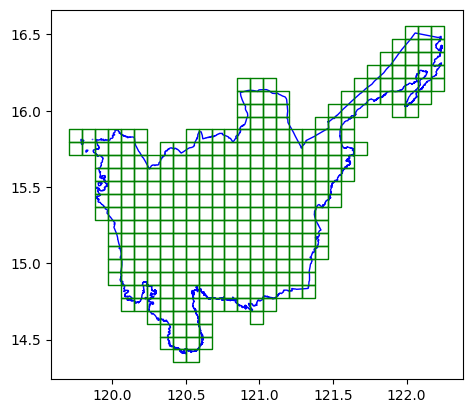

In [ ]:
#| no_test
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = fast_bing_tile_gdf.plot(ax=ax, facecolor="none", edgecolor="green")

Since `FastBingTileGridGenerator` uses a different algorithm to find the tiles inside a polygon, the tiles aren't always exact but it's typically close.

In the case below, there's a 1 tile mismatch. There's 1 tile available in `BingTileGridGenerator` but not in `FastBingTileGridGenerator`. This typically happens on some corners of polygons.

In [ ]:
bing_tile_gdf.shape[0], fast_bing_tile_gdf.shape[0]

(319, 318)

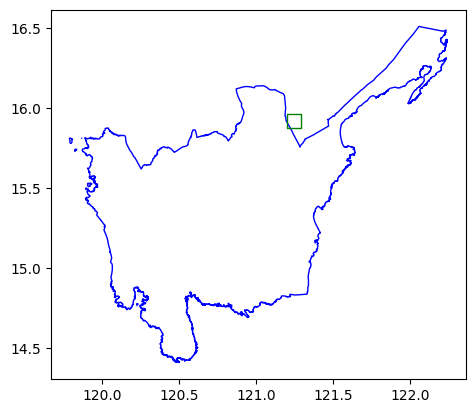

In [ ]:
#| no_test

bool_mask = ~bing_tile_gdf["quadkey"].isin(fast_bing_tile_gdf["quadkey"])
ax = region3_gdf.plot(facecolor="none", edgecolor="blue")
ax = bing_tile_gdf.loc[bool_mask,:].plot(ax=ax, facecolor="none", edgecolor="green")

We can even use a higher zoom_level, say 17, and `FastBingTileGridGenerator` will still run significantly faster than `BingTileGridGenerator` at zoom_level 12 despite the former having ~783 times more grid tiles.

We can also pass in a column name to `unique_id_col` so that the grids can preserve the ID from the AOI. This makes it convenient so you don't have to do another spatial intersection between the tiles gdf and the AOI gdf to get the AOI IDs.

In [ ]:
fast_bing_tile_grid_generator = grids.FastBingTileGridGenerator(17)

In [ ]:
%%time
fast_bing_tile_gdf = fast_bing_tile_grid_generator.generate_grid(region3_gdf, unique_id_col = "Reg_Name")
fast_bing_tile_gdf.head()

CPU times: user 818 ms, sys: 74.7 ms, total: 892 ms
Wall time: 823 ms


,Reg_Name,quadkey,geometry
0,Region III,13230312012200101,"POLYGON ((121.30554 15.02703, 121.30554 15.029..."
1,Region III,13230310200223111,"POLYGON ((120.98145 15.81075, 120.98145 15.813..."
2,Region III,13230310202120220,"POLYGON ((121.02814 15.73146, 121.02814 15.734..."
3,Region III,13230301320212020,"POLYGON ((120.28107 15.50927, 120.28107 15.511..."
4,Region III,13230301322102001,"POLYGON ((120.32776 15.42985, 120.32776 15.432..."


In [ ]:
fast_bing_tile_gdf.shape[0]

249665

In [ ]:
# computes how many more tiles there are in FastBingTileGridGenerator zoom 17 vs BingTileGridGenerator zoom 12
fast_bing_tile_gdf.shape[0]/bing_region3_keys.shape[0]

782.6489028213166